In [1]:
#!pip install -q pgmpy

# Introduction to pgmpy

This is an introduction to the [pgmpy library](http://www.pgmpy.org). By the end of this tutorial you will be able to
- Define and perform operations with potentials (i.e. probability tables)
- Build and display a Bayesian Network
- Load a Bayesian Network from a file and export it

## The problem

**\[BRML\] Example 1.3.** Inspector Clouseau arrives at the scene of a crime. The victim lies dead in the room alongside the possible murder weapon, a knife. The Butler (B) and Maid (M) are the inspector's main suspects and the inspector has a prior belief of 0.6 that the Butler is the murderer, and a prior belief of 0.2 that the Maid is the murderer. These beliefs are independent in the sense that p(B,M) = p(B)p(M). (It is possible that both the Butler and the Maid murdered the victim or neither).


## Defining potentials

We will represent our probability tables as Factors. An instance of DiscreteFactor is initialized as follows:

```python
def __init__(self, variables, cardinality, values, state_names={}):
    """
    Initialize a factor class.

    Defined above, we have the following mapping from variable
    assignments to the index of the row vector in the value field:
    +-----+-----+-----+-------------------+
    |  x1 |  x2 |  x3 |    phi(x1, x2, x3)|
    +-----+-----+-----+-------------------+
    | x1_0| x2_0| x3_0|     phi.value(0)  |
    +-----+-----+-----+-------------------+
    | x1_0| x2_0| x3_1|     phi.value(1)  |
    +-----+-----+-----+-------------------+
    | x1_0| x2_1| x3_0|     phi.value(2)  |
    +-----+-----+-----+-------------------+
    | x1_0| x2_1| x3_1|     phi.value(3)  |
    +-----+-----+-----+-------------------+
    | x1_1| x2_0| x3_0|     phi.value(4)  |
    +-----+-----+-----+-------------------+
    | x1_1| x2_0| x3_1|     phi.value(5)  |
    +-----+-----+-----+-------------------+
    | x1_1| x2_1| x3_0|     phi.value(6)  |
    +-----+-----+-----+-------------------+
    | x1_1| x2_1| x3_1|     phi.value(7)  |
    +-----+-----+-----+-------------------+

    Parameters
    ----------
    variables: list, array-like
        List of variables in the scope of the factor.

    cardinality: list, array_like
        List of cardinalities of each variable. `cardinality` array must have a value
        corresponding to each variable in `variables`.

    values: list, array_like
        List of values of factor.
        A DiscreteFactor's values are stored in a row vector in the value
        using an ordering such that the left-most variables as defined in
        `variables` cycle through their values the fastest.
        
    state_names (optional): dict
        A dict where (key,value)=(variable, list of states)
```

Let's define the factors of our model:

In [2]:
import numpy as np
from pgmpy.factors.discrete import DiscreteFactor, TabularCPD

# Define variables and domains
variables = ["Butler", "Maid", "Knife"]
domains = {"Butler": ["murderer", "not_murderer"],
           "Maid": ["murderer", "not_murderer"],
           "Knife": ["used", "not_used"]}

p = dict() # we'll use this to store our potentials

p["B"] = DiscreteFactor(variables=["Butler"],
                        cardinality=[len(domains["Butler"])],
                        values=[0.6, 0.4],
                        state_names=domains)

print("p(Butler) =\n", p["B"])

p(Butler) =
 +----------------------+---------------+
| Butler               |   phi(Butler) |
+======================+===============+
| Butler(murderer)     |        0.6000 |
+----------------------+---------------+
| Butler(not_murderer) |        0.4000 |
+----------------------+---------------+


Define $P(M)$ according to inspector Clouseau's prior:

In [3]:
p["M"] = DiscreteFactor(variables=["Maid"],
                        cardinality=[len(domains["Maid"])],
                        values=[0.2, 0.8],
                        state_names=domains)
print(p['M'])

+--------------------+-------------+
| Maid               |   phi(Maid) |
+====================+=============+
| Maid(murderer)     |      0.2000 |
+--------------------+-------------+
| Maid(not_murderer) |      0.8000 |
+--------------------+-------------+


Define $P(K|B,M)$ as shown in the table:

|   Knife  |    Butler    |     Maid     | P(Knife\|Butler,Maid) |
|:--------:|:------------:|:------------:|:---------------------:|
|   used   |   murderer   |   murderer   |          0.3          |
|   used   |   murderer   | not_murderer |          0.2          |
|   used   | not_murderer |   murderer   |          0.6          |
|   used   | not_murderer | not_murderer |          0.1          |
| not_used |   murderer   |   murderer   |          0.7          |
| not_used |   murderer   | not_murderer |          0.8          |
| not_used | not_murderer |   murderer   |          0.4          |
| not_used | not_murderer | not_murderer |          0.9          |

In [4]:
p['K|B,M'] = DiscreteFactor(variables=['Knife', 'Butler', 'Maid'],
                            cardinality=[len(domains[domain]) for domain in domains],
                            values = [0.3, 0.2, 0.6, 0.1, 0.7, 0.8, 0.4, 0.9],
                            state_names=domains)

print(p['K|B,M'])

+-----------------+----------------------+--------------------+--------------------------+
| Knife           | Butler               | Maid               |   phi(Knife,Butler,Maid) |
+=================+======================+====================+==========================+
| Knife(used)     | Butler(murderer)     | Maid(murderer)     |                   0.3000 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(murderer)     | Maid(not_murderer) |                   0.2000 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(murderer)     |                   0.6000 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(not_murderer) |                   0.1000 |
+-----------------+----------------------+--------------------+--------------------------+

## Operations with potentials

Let's compute the joint probability from the factored distributions, representing our whole model:

In [5]:
print("p(K,B,M)")
p["K,B,M"] = p["K|B,M"] * p["B"] * p["M"] # not working? did you define p["K|B,M"] and p["M"]?
print(p["K,B,M"])
print("Sum of values: ", np.sum(p["K,B,M"].values)) # should sum to 1

p(K,B,M)
+-----------------+----------------------+--------------------+--------------------------+
| Knife           | Butler               | Maid               |   phi(Knife,Butler,Maid) |
+=================+======================+====================+==========================+
| Knife(used)     | Butler(murderer)     | Maid(murderer)     |                   0.0360 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(murderer)     | Maid(not_murderer) |                   0.0960 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(murderer)     |                   0.0480 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(not_murderer) |                   0.0320 |
+-----------------+----------------------+--------------------+------------------

From p(K,B,M) we can compute other conditional probability tables. For instance, let's compute p(Knife,Butler|Maid).

In [6]:
print("p(K,B|M) = p(K,B,M)/p(M)")
p["K,B|M"] = p["K,B,M"]/p["M"]
print(p["K,B|M"])
print("Sum of values: ", np.sum(p["K,B|M"].values))

p(K,B|M) = p(K,B,M)/p(M)
+-----------------+----------------------+--------------------+--------------------------+
| Knife           | Butler               | Maid               |   phi(Knife,Butler,Maid) |
+=================+======================+====================+==========================+
| Knife(used)     | Butler(murderer)     | Maid(murderer)     |                   0.1800 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(murderer)     | Maid(not_murderer) |                   0.1200 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(murderer)     |                   0.2400 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(not_murderer) |                   0.0400 |
+-----------------+----------------------+--------------------+--

We can also reduce the table to a specific value, e.g. when Maid=murderer.

The method ```reduce``` needs a list of tuples: ```[(var_0, value_0), var_1, value_1, ...]```

In [7]:
p_KB_Mm = p["K,B|M"].reduce([("Maid", "murderer")], inplace=False)
print("p(K,B|M=murderer)")
print(p_KB_Mm)
print("Sum of values: ", np.sum(p_KB_Mm.values))

p(K,B|M=murderer)
+-----------------+----------------------+---------------------+
| Knife           | Butler               |   phi(Knife,Butler) |
+=================+======================+=====================+
| Knife(used)     | Butler(murderer)     |              0.1800 |
+-----------------+----------------------+---------------------+
| Knife(used)     | Butler(not_murderer) |              0.2400 |
+-----------------+----------------------+---------------------+
| Knife(not_used) | Butler(murderer)     |              0.4200 |
+-----------------+----------------------+---------------------+
| Knife(not_used) | Butler(not_murderer) |              0.1600 |
+-----------------+----------------------+---------------------+
Sum of values:  0.9999999999999999


To marginalize over one variable we can use the method ```marginalize```. It receives a list of variables ```[var_0, var_1, ...]```.

In [8]:
p_M = p["K,B,M"].marginalize(["Knife", "Butler"], inplace=False)
print(p_M)

+--------------------+-------------+
| Maid               |   phi(Maid) |
+====================+=============+
| Maid(murderer)     |      0.2000 |
+--------------------+-------------+
| Maid(not_murderer) |      0.8000 |
+--------------------+-------------+


Note that we used the argument ```inplace=False```.

**Warning**: pgmpy modifies the given instance by default. To create a new instance when calling a method we need to specify inplace=False. For instance, if we don't specify inplace=False, when marginalizing P(K,B,M) to obtain p(M) we would be modifying the instance P(K,B,M), losing the information about K and B. Let's see an example:

In [9]:
# First we create a copy, since we're going to lose the information stored in pKBM
p_KBM = p["K,B,M"].copy()
# Marginalizing it with inplace=True (default) will return None, it is intended to be used as a procedure:
p_M_2 = p_KBM.marginalize(["Knife", "Butler"])
print("P(Maid)?:")
print(p_M_2)
print("")
print("P(Knife, Butler, Maid)?:")
print(p_KBM)

P(Maid)?:
None

P(Knife, Butler, Maid)?:
+--------------------+-------------+
| Maid               |   phi(Maid) |
+====================+=============+
| Maid(murderer)     |      0.2000 |
+--------------------+-------------+
| Maid(not_murderer) |      0.8000 |
+--------------------+-------------+


#### Exercise
So far we have seen how to multiply and divide factors, perform marginalizations, and reduce the table to one variable value. Now, compute the following probability tables:
- P(Knife)
- P(Butler, Maid | Knife=used)
- P(Butler | Knife)
- P(Maid | Butler)
- P(Maid | Knife=notused, Butler=notmurderer)

Troubleshoting: Most errors come from executing methods like marginalize and reduce with ```inplace=True``` (default). You need to execute previous cells to recover the value of the factor. It may be easiest to run all cells (```Cell -> Run all``` or ```Cell-> Run all above```) or even to restart the kernel (```Kernel -> Restart & Run All```).

## TabularCPD and JointProbabilityDistribution

In pgmpy, there are two classes that inherit from DiscreteFactor:
- TabularCPD
- JointProbabilityDistribution

In general, **we will not use these two classes** to represent and perform operations between potentials (we show why later).

### Tabular

A TabularCPD can be created as follows:
```python
def __init__(self, variable, variable_card, values, evidence=None, evidence_card=None, state_names={})
"""
    Defines the conditional probability distribution table (cpd table)

    Parameters
    ----------
    variable: int, string (any hashable python object)
        The variable whose CPD is defined.

    variable_card: integer
        cardinality of variable

    values: 2d array, 2d list or 2d tuple
        values of the cpd table

    evidence: array-like
        evidences(if any) w.r.t. which cpd is defined

    evidence_card: integer, array-like
        cardinality of evidences (if any)

    Examples
    --------
    For a distribution of P(grade|diff, intel)

    +-------+--------------------+------------------+
    |diff   |      easy          |    hard          |
    +-------+-----+------+-------+------+----+------+
    |intel  |dumb |  avg | smart | dumb |avg |smart |
    +-------+-----+------+-------+------+----+------+
    |gradeA |0.1  |  0.1 |  0.1  | 0.1  |0.1 | 0.1  |
    +-------+-----+------+-------+------+----+------+
    |gradeB |0.1  |  0.1 |  0.1  | 0.1  |0.1 | 0.1  |
    +-------+-----+------+-------+------+----+------+
    |gradeC |0.8  |  0.8 |  0.8  | 0.8  |0.8 | 0.8  |
    +-------+-----+------+-------+------+----+------+

    values should be
    [[0.1,0.1,0.1,0.1,0.1,0.1],
    [0.1,0.1,0.1,0.1,0.1,0.1],
    [0.8,0.8,0.8,0.8,0.8,0.8]]

    >>> cpd = TabularCPD('grade',3,[[0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.8,0.8,0.8,0.8,0.8,0.8]],
                                    evidence=['diff', 'intel'], evidence_card=[2,3])

```

Let's create p(Knife|Butler,Maid) as a TabularCPD:

In [10]:
from pgmpy.factors.discrete import TabularCPD

cpd = dict()

cpd["K|B,M"] = TabularCPD(variable="Knife",
                         variable_card=len(domains["Knife"]),
                         evidence=["Butler", "Maid"],
                         evidence_card=[len(domains["Butler"]), len(domains["Maid"])],
                         values=[[0.3, 0.2, 0.6, 0.1],
                                 [0.7, 0.8, 0.4, 0.9]])

print(repr(cpd["K|B,M"]))
print(cpd["K|B,M"])

<TabularCPD representing P(Knife:2 | Butler:2, Maid:2) at 0x7ffa97e5c7c0>
+----------+-----------+-----------+-----------+-----------+
| Butler   | Butler(0) | Butler(0) | Butler(1) | Butler(1) |
+----------+-----------+-----------+-----------+-----------+
| Maid     | Maid(0)   | Maid(1)   | Maid(0)   | Maid(1)   |
+----------+-----------+-----------+-----------+-----------+
| Knife(0) | 0.3       | 0.2       | 0.6       | 0.1       |
+----------+-----------+-----------+-----------+-----------+
| Knife(1) | 0.7       | 0.8       | 0.4       | 0.9       |
+----------+-----------+-----------+-----------+-----------+


Note that apart from separating the variables, we need to specify the values in a different way. TabularCPD contains the same information as our previous definition as a DiscreteFactor, but rearranged in a table of size 2x4. Therefore, it is equal to our previous definition (although not the same object, of course):

In [11]:
print('cpd["K|B,M"] equal to p["K|B,M"]:', cpd["K|B,M"] == p["K|B,M"])
print('cpd["K|B,M"] is p["K|B,M"]:', cpd["K|B,M"] is p["K|B,M"])

cpd["K|B,M"] equal to p["K|B,M"]: False
cpd["K|B,M"] is p["K|B,M"]: False


We can get a DiscreteFactor from a TabularCPD with the method ```to_factor```. However, it won't keep the state names:

In [12]:
print(cpd["K|B,M"].to_factor())

+----------+-----------+---------+--------------------------+
| Knife    | Butler    | Maid    |   phi(Knife,Butler,Maid) |
+==========+===========+=========+==========================+
| Knife(0) | Butler(0) | Maid(0) |                   0.3000 |
+----------+-----------+---------+--------------------------+
| Knife(0) | Butler(0) | Maid(1) |                   0.2000 |
+----------+-----------+---------+--------------------------+
| Knife(0) | Butler(1) | Maid(0) |                   0.6000 |
+----------+-----------+---------+--------------------------+
| Knife(0) | Butler(1) | Maid(1) |                   0.1000 |
+----------+-----------+---------+--------------------------+
| Knife(1) | Butler(0) | Maid(0) |                   0.7000 |
+----------+-----------+---------+--------------------------+
| Knife(1) | Butler(0) | Maid(1) |                   0.8000 |
+----------+-----------+---------+--------------------------+
| Knife(1) | Butler(1) | Maid(0) |                   0.4000 |
+-------

### What is the problem of TabularCPD?
As far as we know, TabularCPD inherits from DiscreteFactor and represents a conditional probability distribution. So why don't we use it from the begining? What is wrong with it? Let's try to perform operations with it. What happens when we compute p(Knife,Maid|Butler) = p(Knife|Butler,Maid)p(Maid)?

In [13]:
cpd_KM_B = cpd["K|B,M"]*p["M"]
print(repr(cpd_KM_B))
print(cpd_KM_B)

<TabularCPD representing P(Knife:2 | Butler:2, Maid:2) at 0x7ffa97cd5c00>
+-----------------+-----+----------------------+
| Butler          | ... | Butler(not_murderer) |
+-----------------+-----+----------------------+
| Maid            | ... | Maid(not_murderer)   |
+-----------------+-----+----------------------+
| Knife(used)     | ... | 0.08000000000000002  |
+-----------------+-----+----------------------+
| Knife(not_used) | ... | 0.7200000000000001   |
+-----------------+-----+----------------------+


This seems wrong. It shows it as P(Knife|Butler,Maid) instead of P(Knife,Maid|Butler). This is because, in pgmpy, performing an operation in a TabularCPD returns another TabularCPD. A TabularCPD is not general enough to represent this, since it only allows one variable in the left-hand side. The values of the table, however, are ok, but the interpretation (the class) is not. This is why we will **always use factors** to perform operations.

In [14]:
p_KM_B = cpd_KM_B.to_factor()
print("P(Knife,Maid|Butler):")
print(p_KM_B) # the values of the probability table are ok, their interpretation (the class) was not

P(Knife,Maid|Butler):
+-----------------+----------------------+--------------------+--------------------------+
| Knife           | Butler               | Maid               |   phi(Knife,Butler,Maid) |
+=================+======================+====================+==========================+
| Knife(used)     | Butler(murderer)     | Maid(murderer)     |                   0.0600 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(murderer)     | Maid(not_murderer) |                   0.1600 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(murderer)     |                   0.1200 |
+-----------------+----------------------+--------------------+--------------------------+
| Knife(used)     | Butler(not_murderer) | Maid(not_murderer) |                   0.0800 |
+-----------------+----------------------+--------------------+-----

This is even worse if we get a joint probability distribution:

In [15]:
joint_from_cpd = cpd["K|B,M"] * p["B"] * p["M"]
print(repr(joint_from_cpd))
print(joint_from_cpd)

<TabularCPD representing P(Knife:2 | Butler:2, Maid:2) at 0x7ffa97cd5bd0>
+-----------------+-----+----------------------+
| Butler          | ... | Butler(not_murderer) |
+-----------------+-----+----------------------+
| Maid            | ... | Maid(not_murderer)   |
+-----------------+-----+----------------------+
| Knife(used)     | ... | 0.03200000000000001  |
+-----------------+-----+----------------------+
| Knife(not_used) | ... | 0.28800000000000003  |
+-----------------+-----+----------------------+


This is completely wrong: there should be no conditioning at all, but pgmpy does not know that, it just performs the operations and returns them in a TabularCPD object. Again, the values are ok, we can check it is a distribution since they sum to 1. Also, checking with ```is_valid_cpd``` tells us that this is not a well-defined CPD, as expected.

In [16]:
print("Valid CPD:", joint_from_cpd.is_valid_cpd())
print("Sum of values:", np.sum(joint_from_cpd.values))

Valid CPD: False
Sum of values: 1.0


Why do we need TabularCPD at all, then? Well, when defining a Bayesian Network, we will need to specify the probability tables as a list of TabularCPD instances. We recommend that you **work using DiscreteFactors and translate them to TabularCPDs when you need them to specify the graphical model**.

Here we provide a function that given a factor and a variable, it returns the corresponding TabularCPD.

In [17]:
def to_cpd(phi, x):
    """
    Returns a TabularCPD object from a DiscreteFactor. For a given factor phi(x_0, ..., x_n)
    and a variable x_i, it interprets the factor as a CPD P(x_i|Y), where Y is the set of all
    variables in phi except x_i. I.e. P(x_i|x_0, ..., x_{i-1}, x_{i+1}, ..., x_n).
    It also checks that the factor is a valid conditional probability distribution.
    """
    assert x in phi.variables
    idx = phi.variables.index(x)
    card = list(phi.cardinality)
    var_card = card[idx]
    evidence_card = card[:idx] + card[idx+1:]
    values = np.moveaxis(phi.values, idx, 0) # move variable x to dimension 0
    return TabularCPD(variable=x,
                      variable_card=var_card,
                      evidence=phi.variables[:idx] + phi.variables[idx+1:],
                      evidence_card=evidence_card,
                      values=values.reshape(var_card, int(np.prod(evidence_card))), # int cast since np.prod([])=1.0
                      state_names=phi.state_names)

In [18]:
cpd["K|B,M"] = to_cpd(p["K|B,M"], "Knife")
print(cpd["K|B,M"])

+-----------------+-----+----------------------+
| Butler          | ... | Butler(not_murderer) |
+-----------------+-----+----------------------+
| Maid            | ... | Maid(not_murderer)   |
+-----------------+-----+----------------------+
| Knife(used)     | ... | 0.1                  |
+-----------------+-----+----------------------+
| Knife(not_used) | ... | 0.9                  |
+-----------------+-----+----------------------+


Try it with the tables p(Knife), p(Butler|Knife), p(Maid|Knife) and p(Maid|Knife,Butler) that you have computed before.

Note that we cannot try it with p(Butler,Maid|Knife), for instance, because TabularCPD cannot express such CPD.

### JointProbabilityDistribution
We also have another class for Joint Probability Distributions (JPD). This class also inherits from DiscreteFactor and offers some functionality specific to JPDs. Similar to TabularCPDs, when performing operations on a JointProbabilityDistribution instance, we will get another instance of the same class. Again, the values of the probability table will be right, but they should not be interpreted as a JPD. We also provide a function to go from DiscreteFactor to JointProbabilityDistribution.

In [19]:
from pgmpy.factors.discrete import JointProbabilityDistribution

def to_jdp(p):
    return JointProbabilityDistribution(variables=p.variables,
                                        cardinality=p.cardinality,
                                        values=p.values)

In [20]:
jdp_KBM = to_jdp(p["K,B,M"]) # if this does not work it is most probably because you forgot an "inplace=False" somewhere
print(repr(jdp_KBM))
print(jdp_KBM) # note the P() instead of phi() in the representation

<Joint Distribution representing P(Knife:2, Butler:2, Maid:2) at 0x7ffa97cd67a0>
+----------+-----------+---------+------------------------+
| Knife    | Butler    | Maid    |   P(Knife,Butler,Maid) |
+==========+===========+=========+========================+
| Knife(0) | Butler(0) | Maid(0) |                 0.0360 |
+----------+-----------+---------+------------------------+
| Knife(0) | Butler(0) | Maid(1) |                 0.0960 |
+----------+-----------+---------+------------------------+
| Knife(0) | Butler(1) | Maid(0) |                 0.0480 |
+----------+-----------+---------+------------------------+
| Knife(0) | Butler(1) | Maid(1) |                 0.0320 |
+----------+-----------+---------+------------------------+
| Knife(1) | Butler(0) | Maid(0) |                 0.0840 |
+----------+-----------+---------+------------------------+
| Knife(1) | Butler(0) | Maid(1) |                 0.3840 |
+----------+-----------+---------+------------------------+
| Knife(1) | Butler

## Bayesian Networks

From the documentation:
```python
class BayesianModel(DAG):
    """
    Base class for bayesian model.

    A models stores nodes and edges with conditional probability
    distribution (cpd) and other attributes.

    models hold directed edges.  Self loops are not allowed neither
    multiple (parallel) edges.

    Nodes can be any hashable python object.

    Edges are represented as links between nodes.

    Parameters
    ----------
    data : input graph
        Data to initialize graph.  If data=None (default) an empty
        graph is created.  The data can be an edge list, or any
        NetworkX graph object.
```

### Creating a Bayesian Network

Let's create our model, add the CPDs and check it:

In [21]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([("Butler", "Knife"), ("Maid", "Knife")])
cpd_B = to_cpd(p["B"], "Butler")
cpd_M = to_cpd(p["M"], "Maid")
cpd_K_BM = to_cpd(p["K|B,M"], "Knife")
model.add_cpds(cpd_M, cpd_B, cpd_K_BM) # the order is not important
print("Model OK:", model.check_model())

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model OK: True


We can get the list of CPDs with ```model.get_cpds()```:

In [22]:
print("CPDs list:")
print(model.get_cpds())

print("")
print("CPD for Butler:")
print(model.get_cpds("Butler"))

print("")
print("CPD for Knife:")
print(model.get_cpds("Knife"))

CPDs list:
[<TabularCPD representing P(Maid:2) at 0x7ff9b9dd2cb0>, <TabularCPD representing P(Butler:2) at 0x7ffa97cd66e0>, <TabularCPD representing P(Knife:2 | Butler:2, Maid:2) at 0x7ffa97cd5ea0>]

CPD for Butler:
+----------------------+-----+
| Butler(murderer)     | 0.6 |
+----------------------+-----+
| Butler(not_murderer) | 0.4 |
+----------------------+-----+

CPD for Knife:
+-----------------+-----+----------------------+
| Butler          | ... | Butler(not_murderer) |
+-----------------+-----+----------------------+
| Maid            | ... | Maid(not_murderer)   |
+-----------------+-----+----------------------+
| Knife(used)     | ... | 0.1                  |
+-----------------+-----+----------------------+
| Knife(not_used) | ... | 0.9                  |
+-----------------+-----+----------------------+


We can also check the independencies with ```model.local_independencies(vars)```. Try it out:

### Displaying the network
pgmpy uses networkx for graph structure. We can plot the network using networkx.draw

INFO:matplotlib.font_manager:generated new fontManager


StopIteration: 

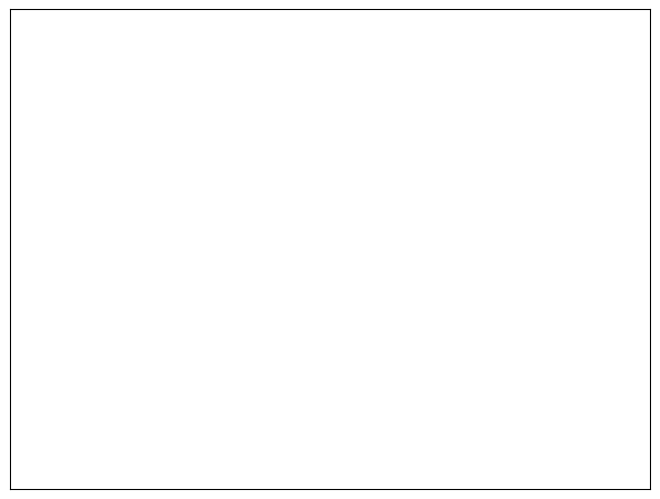

In [23]:
import networkx as nx

nx.draw(model, with_labels=True)

### Writing a network to a file

There are many file formats for saving our model. We are going to use the BIF format. You can import the ```BIFWriter``` class from ```pgmpy.readwrite```. Write our model to file named "closeau.bif" with the function ```BIFWriter.write_bif```.

In case you are not familiar with files in Google Colab checkout this <a href='https://neptune.ai/blog/google-colab-dealing-with-files'> link</a>.

You should now have a file with the following information:

```
network unknown {
}
variable Butler {
    type discrete [ 2 ] { Butler_0, Butler_1 };
}
variable Knife {
    type discrete [ 2 ] { Knife_0, Knife_1 };
}
variable Maid {
    type discrete [ 2 ] { Maid_0, Maid_1 };
}
probability ( Butler ) {
    table 0.6, 0.4 ;
}
probability ( Knife | Butler, Maid ) {
    table 0.3, 0.2, 0.6, 0.1, 0.7, 0.8, 0.4, 0.9 ;
}
probability ( Maid ) {
    table 0.2, 0.8 ;
}
```

As you can see it is quite straightforward: we define the variables, with their type, cardinality and state names together with the probability tables.

For other BIF models, check this website: https://www.bnlearn.com/bnrepository/

### Reading a network from a file

To import a Bayesian model from a BIF file, we can use the ```BIFReader``` class: ```BIFReader("bif_test.bif").get_model()```.

Choose a network from the bnlearn repository and download the BIF file. Have a look at the file, and change some parameters. Load the file with the method shown above. Display it and check the independencies.